In [22]:
# Module import
from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

import astropy.units as u

# Ipython magics
%load_ext autoreload
%autoreload 2
%matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl
%reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Initializing objects:**

In [23]:
True & False

False

In [24]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end =  365
my_dt = 1/24 # [days]

# objects
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt)
print('Sat created')
alpha_sirio = 101.28  # right ascension
delta_sirio = -16.7161  # declination
sirio = Source("sirio", alpha_sirio, delta_sirio, 379.21, -546.05, -1223.14, -7.6)
sirio2 = Source("sirio2", alpha_sirio, delta_sirio, 379.21, -546.05, -1223.14, -7.6) #98, -15, 350, -500, -1000, -13.9)
print('Source created')
scanSirio = Scanner() 
print('Scanner created')
sirio.reset()
print([sirio.alpha, sirio.delta, sirio.parallax, sirio.mu_alpha_dx, sirio.mu_delta])

Sat created
Source created
Scanner created
[1.767669466419857, -0.29175098309262415, 1.8384619601354712e-06, -6.9464484158848486e-09, -1.6246438518145694e-08]


<IPython.core.display.Javascript object>


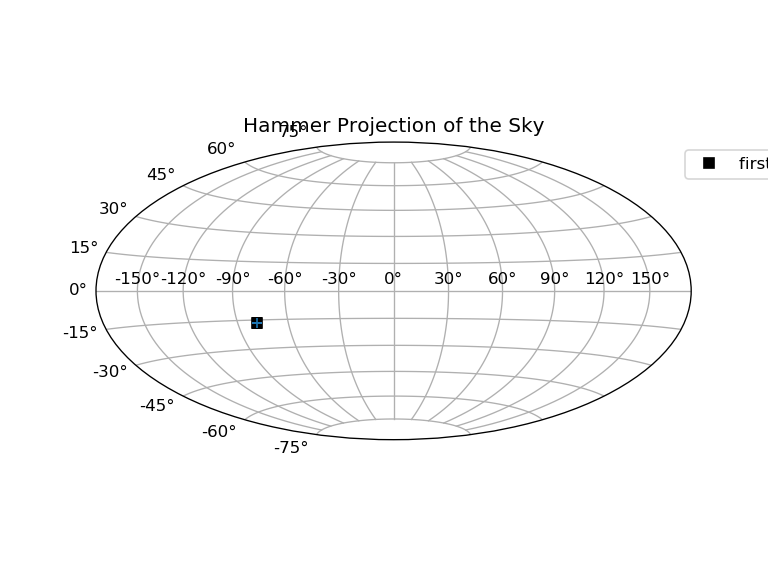

In [25]:
fig = plt.figure()
plt.subplot(111, projection="hammer")
alphas = []
deltas = []

for i, s in enumerate([sirio, sirio2]):
    alpha, delta = s.alpha-np.pi, s.delta
    #print(i, alpha, delta)
    alphas.append(alpha)
    deltas.append(delta)
    if i==0:
        plt.plot(alpha, delta, 'sk', label='first star')
    else:
        plt.plot( alpha, delta,'+')
        pass


plt.title("Hammer Projection of the Sky")
plt.legend(loc=9, bbox_to_anchor=(1.1, 1))
plt.grid(True)

# **Scan**

In [26]:
1/24*3

0.125

In [44]:
scanSirio.scan(gaia, sirio, ti=t_init, tf=t_end)
#print('How many wide times?  {}'.format(len(scanSirio.times_wide_scan)))
#print('How many coarse times?  {}'.format(len(scanSirio.times_coarse_scan)))
print('How many observation time?  {}'.format(len(scanSirio.obs_times)))
#print('How many roots?  {}'.format(len(scanSirio.roots)))
# pd.DataFrame(scanSirio.roots)


Starting scan with time from 0 to 365 days
time for constraints t: 9.59928050342146 is 0.001352071762084961
time for constraints t: 41.52657344437703 is 0.0012204647064208984
time for constraints t: 41.674492491092934 is 0.0009489059448242188
time for constraints t: 89.30336272964743 is 0.0013821125030517578
time for constraints t: 89.4512822074818 is 0.0009658336639404297
time for constraints t: 100.44719211104454 is 0.0011246204376220703
time for constraints t: 100.79928071850998 is 0.0012488365173339844
time for constraints t: 149.54118307985135 is 0.0013036727905273438
time for constraints t: 214.87177106856507 is 0.0013232231140136719
time for constraints t: 215.01969611206883 is 0.0011458396911621094
time for constraints t: 267.2355621252658 is 0.0012998580932617188
time for constraints t: 267.38349060809185 is 0.0010030269622802734
time for constraints t: 267.7355916171663 is 0.0015583038330078125
time for constraints t: 293.7262317535625 is 0.0013110637664794922
time for constr

In [45]:
scanSirio.compute_angles_eta_zeta(gaia, sirio)
scanSirio.eta_scanned

[-3.774758283725532e-15,
 -5.329070518200751e-15,
 4.651834473179406e-14,
 2.398081733190338e-14,
 8.315570454442422e-14,
 2.1871393585115584e-14,
 4.118927421359331e-14,
 -1.021405182655144e-14,
 -5.295763827461997e-14,
 3.441691376337985e-14,
 -2.716715741257758e-13,
 6.938893903907228e-13,
 -1.6397994073713562e-13,
 7.915890165577366e-14,
 -2.3514523661560816e-13,
 5.678790770957676e-13,
 -3.647082635893639e-13,
 -2.227107387398064e-13,
 -1.4555023852835802e-13]

In [46]:
scanSirio.obs_times_FFoV

[]

In [47]:
scanSirio.obs_times_PFoV

[]

In [48]:
print(scanSirio.scanner_error())
print(np.mean(scanSirio.zeta_scanned))

6.106226635438361e-15
0.0005181865959903837


In [49]:
for t in scanSirio.obs_times:
    eta, zeta = observed_field_angles(sirio, gaia.func_attitude(t), gaia, t, True)
    print(eta, zeta)

-3.774758283725532e-15 -0.0010955206925165287
-5.329070518200751e-15 -0.003767810608079999
4.651834473179406e-14 0.0050735940171764094
2.398081733190338e-14 0.0017688420802908645
8.315570454442422e-14 -0.004751366149897709
2.1871393585115584e-14 -0.007403069222947154
4.118927421359331e-14 0.006180940602100285
-1.021405182655144e-14 -0.0024958887107194277
-5.295763827461997e-14 0.005748837213948942
3.441691376337985e-14 -0.004882429122586927
-2.716715741257758e-13 -0.0021103190316916886
6.938893903907228e-13 -0.00031753754025284073
-1.6397994073713562e-13 0.0077860796035220505
7.915890165577366e-14 0.006108571425631492
-2.3514523661560816e-13 0.0026314596380949654
5.678790770957676e-13 -0.0017329370691553127
-3.647082635893639e-13 -0.005301823782857662
-2.227107387398064e-13 0.0003444156959753229
-1.4555023852835802e-13 0.008061506977782207


# **Plots:**

In [50]:
sat = gaia
source = sirio
satellite = gaia 
scan = scanSirio


In [51]:
def get_obs_in_CoMRS(source, sat, t):
        
    attitude = sat.func_attitude(t)
    phi, zeta = observed_field_angles(source, attitude, sat, t, double_telescope=False)  # iven if we have double telescope
    z_axis = np.array([0, 0, 1])
    field_index = np.sign(phi)
    
    eta = field_index * const.Gamma_c / 2
    
    quat1 = Quaternion(vector=z_axis, angle=eta)
    Sx_rot_eta = ft.rotate_by_quaternion(quat1, np.array([1, 0, 0]))
    
    
    vect = np.cross(Sx_rot_eta / np.linalg.norm(Sx_rot_eta), z_axis)
    quat2 = Quaternion(vector=vect, angle=zeta)
    Sx_rot_eta_zeta = ft.rotate_by_quaternion(quat2, Sx_rot_eta)
    
    obs_in_CoMRS = ft.xyz_to_lmn(attitude, Sx_rot_eta_zeta)
    return obs_in_CoMRS

def vector_error(t):
    u_lmn_unit = source.unit_topocentric_function(sat, t)
    vector_error_lmn = u_lmn_unit - sat.func_x_axis_lmn(t)  # Error vector
    vector_error_xyz = ft.lmn_to_xyz(sat.func_attitude(t), vector_error_lmn)
    return vector_error_xyz

def rad_to_mas(angle):
    """:input: angle in rad
       :output: angle in mas"""
    return angle*u.rad.to(u.mas)


In [52]:
print(scanSirio.obs_times)

[9.59928050342146, 41.52657344437703, 41.674492491092934, 89.30336272964743, 89.4512822074818, 100.44719211104454, 100.79928071850998, 149.54118307985135, 214.87177106856507, 215.01969611206883, 267.2355621252658, 267.38349060809185, 267.7355916171663, 293.7262317535625, 293.8741545372327, 294.22626288012776, 294.37419495233235, 352.58641638731797, 352.73434154042053]


<IPython.core.display.Javascript object>


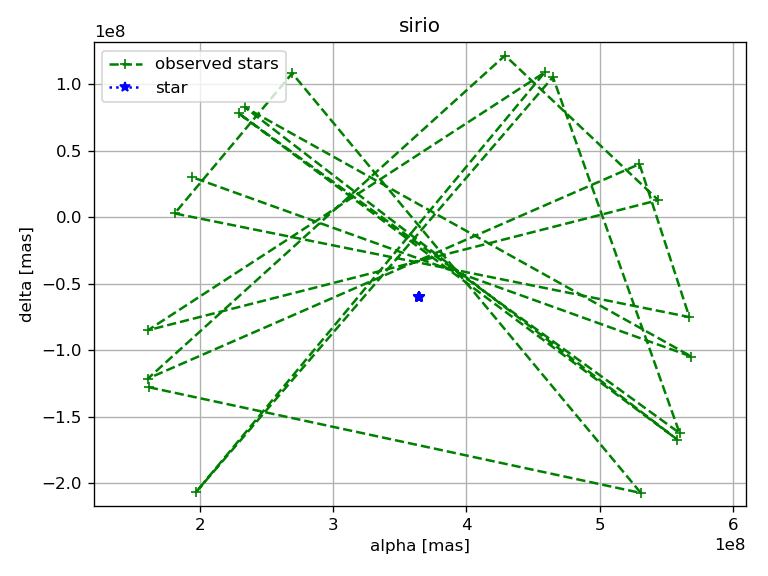

19

In [53]:


alphas_obs, deltas_obs, radius_obs = ([], [], [])
star_alphas, star_deltas, star_radius = ([], [], [])
z_alphas, z_deltas = ([], [])
green_alphas, green_deltas = ([], [])

angle_list = [(star_alphas, star_deltas),
              (alphas_obs, deltas_obs),
              (z_alphas, z_deltas),
              (green_alphas, green_deltas)]

plt.figure()
# for each of the observed times we plot the position of the x-axis in lmn
# of the scanner
for i, t in enumerate(scan.obs_times):

    alpha, delta, radius = ft.vector_to_polar(satellite.func_x_axis_lmn(t))
    alphas_obs.append( rad_to_mas(alpha % (2 * np.pi)))
    deltas_obs.append( rad_to_mas(delta))
    # radius_obs.append(radius)
    # source.set_time(t)
    # star_alphas.append(source.alpha)
    # star_deltas.append(source.delta)
    alpha2, delta2, _, _ = source.topocentric_angles(satellite, t)
    star_alphas.append( rad_to_mas(alpha2))
    star_deltas.append( rad_to_mas(delta2))
    # star_deltas.append(source.radius)

    xaxis = satellite.func_x_axis_lmn(t)
    zaxis = satellite.func_z_axis_lmn(t)
    
    

    vectorz1 = xaxis + np.radians(0.5) * zaxis
    vectorz2 = xaxis - np.radians(0.5) * zaxis

    z_alpha_1, z_delta_1, _ = ft.vector_to_polar(vectorz1)
    z_alpha_2, z_delta_2, _ = ft.vector_to_polar(vectorz2)

    z_alphas.append([rad_to_mas(z_alpha_1), rad_to_mas(z_alpha_2)])
    z_deltas.append([rad_to_mas(z_delta_1), rad_to_mas(z_delta_2)])
    
    # For the observations! ##################################
    xaxis = satellite.func_x_axis_lmn(t)
    zaxis = satellite.func_z_axis_lmn(t)
    # ft.xyz_to_lmn(satellite.func_attitude(t), np.array([1, 0, 0]))
    v_error = vector_error(t)
    vectorz1 = xaxis + v_error[2]*zaxis

    green_alpha, green_delta, _ = ft.vector_to_polar(vectorz1)
    green_alphas.append(rad_to_mas(green_alpha))
    green_deltas.append(rad_to_mas(green_delta))
    # end for observations ###################################
    

for alphas, deltas in angle_list:
    # alphas*u.rad.to(u.mas)
    # deltas*u.rad.to(u.mas)
    pass

# For each couple of ([alpha1,alpha2],[delta1,delta2])
for alpha_delta in zip(z_alphas, z_deltas):
    # plt.plot(alpha_delta[0], alpha_delta[1], 'yo-')
    pass
# plt.plot(alphas_obs, deltas_obs, 'ro--', label='observations')  # plot observation as re dots

plt.plot(green_alphas, green_deltas, 'g+--', label='observed stars')
plt.plot(star_alphas, star_deltas, 'b*:', label='star')  # plot stars as blu stars

plt.legend(loc='upper left'), plt.title('%s' % source.name)
plt.xlabel('alpha [mas]'), plt.ylabel('delta [mas]')
plt.axis('equal'), plt.tight_layout()
plt.margins(0.1), plt.grid()
plt.show()
len(star_alphas)

<IPython.core.display.Javascript object>


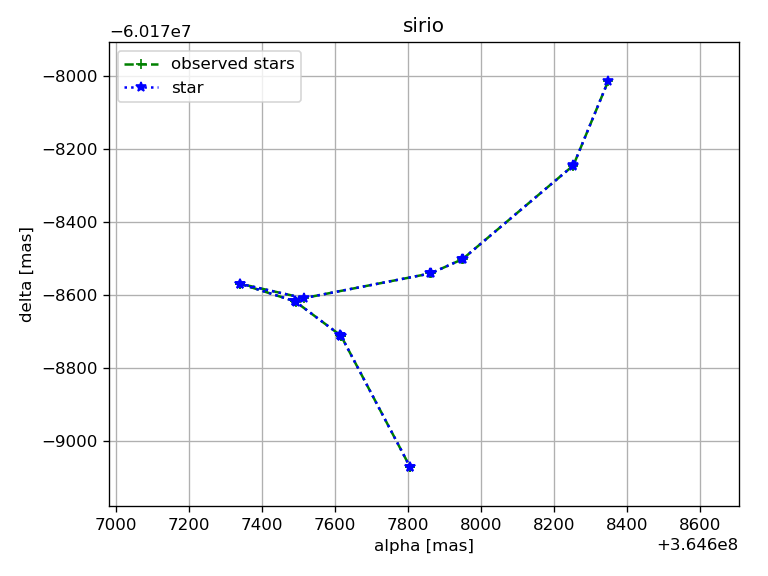

19

In [56]:


alphas_obs, deltas_obs, radius_obs = ([], [], [])
star_alphas, star_deltas, star_radius = ([], [], [])
z_alphas, z_deltas = ([], [])
green_alphas, green_deltas = ([], [])

angle_list = [(star_alphas, star_deltas),
              (alphas_obs, deltas_obs),
              (z_alphas, z_deltas),
              (green_alphas, green_deltas)]

plt.figure()
# for each of the observed times we plot the position of the x-axis in lmn
# of the scanner
for i, t in enumerate(scan.obs_times):

    alpha2, delta2, _, _ = source.topocentric_angles(satellite, t)
    star_alphas.append( rad_to_mas(alpha2))
    star_deltas.append( rad_to_mas(delta2))
    # star_deltas.append(source.radius)
    
    # For the observations! ##################################
    xaxis = satellite.func_x_axis_lmn(t)
    zaxis = satellite.func_z_axis_lmn(t)
    
    """if t in scan.obs_times_PFoV:
        zaxis = satellite.func_z_axis_lmn(t+3/24)
        PFoV = get_PFoV_CoMRS(source, satellite, t)
        v_error = vector_error(t+3/24)"""
    vectorz1 = get_obs_in_CoMRS(source, satellite, t)

    green_alpha, green_delta, _ = ft.vector_to_polar(vectorz1)
    green_alphas.append(rad_to_mas(green_alpha))
    green_deltas.append(rad_to_mas(green_delta))
        
    """if t in scan.obs_times_FFoV:
        zaxis = satellite.func_z_axis_lmn(t+3/24)
        FFoV = get_FFoV_CoMRS(satellite, t)
        v_error = vector_error(t+3/24)
        vectorz1 = FFoV + v_error[2]*zaxis

        green_alpha, green_delta, _ = ft.vector_to_polar(vectorz1)
        green_alphas.append(rad_to_mas(green_alpha))
        green_deltas.append(rad_to_mas(green_delta))"""
    
    # end for observations ###################################
    
    

plt.plot(green_alphas, green_deltas, 'g+--', label='observed stars')
plt.plot(star_alphas, star_deltas, 'b*:', label='star')  # plot stars as blu stars

plt.legend(loc='upper left'), plt.title('%s' % source.name)
plt.xlabel('alpha [mas]'), plt.ylabel('delta [mas]')
plt.axis('equal'), plt.tight_layout()
plt.margins(0.1), plt.grid()
plt.show()
len(star_alphas)

In [54]:
# scanSirio.reset(True)

In [57]:
scanSirio.double_telescope

True

In [58]:
scanSirio.scanner_error()

6.106226635438361e-15

# **2- Combine with solver:**

In [59]:
my_sirio = Calc_source(scanSirio.obs_times, source=sirio) 

print('real:', my_sirio.s_params)
my_sirio.set_params(my_sirio.s_params + my_sirio.s_params*1e-10)
print('noised:', my_sirio.s_params)
# Solver = Agis(gaia, [my_sirio], [sirio], updating='source', double_telescope=True)

real: [ 1.76766947e+00 -2.91750983e-01  1.83846196e-06 -6.94644842e-09
 -1.62464385e-08]
noised: [ 1.76766947e+00 -2.91750983e-01  1.83846196e-06 -6.94644842e-09
 -1.62464385e-08]


In [60]:
s = np.zeros(5)
sirio.reset()  # resets the source parameters at time t=0
#for i, t_L in enumerate(my_observations):
noise = 0.02 / 1
s[0] =  sirio.alpha + noise
s[1] =  sirio.delta + noise
s[2] =  sirio.parallax - sirio.parallax/ 1000
s[3] =  sirio.mu_alpha_dx + sirio.mu_alpha_dx*0.01
s[4] =  sirio.mu_delta + sirio.mu_delta*0.01

my_sirio = Calc_source('sirio', scanSirio.obs_times, s, sirio.mu_radial) 
Solver = Agis(gaia, [my_sirio], [sirio], updating='scanned source', double_telescope=True)

In [64]:
# Solver.reset_iterations()
Solver.iterate(10)

***** Iteration: 31 *****
Error after iteration: 2.368412378497562e-31
***** Iteration: 32 *****
Error after iteration: 1.9710473277501153e-31
***** Iteration: 33 *****
Error after iteration: 4.377086281247301e-31
***** Iteration: 34 *****
Error after iteration: 4.509414530893166e-31
***** Iteration: 35 *****
Error after iteration: 2.693474182319151e-31
***** Iteration: 36 *****
Error after iteration: 6.659243235270225e-31
***** Iteration: 37 *****
Error after iteration: 6.03325393724265e-31
***** Iteration: 38 *****
Error after iteration: 5.7423331913463435e-31
***** Iteration: 39 *****
Error after iteration: 3.9615043888336495e-31
***** Iteration: 40 *****
Error after iteration: 4.18397045630869e-31


In [42]:
gaia.wz

25.132741228718345

# **See iterations**

<IPython.core.display.Javascript object>


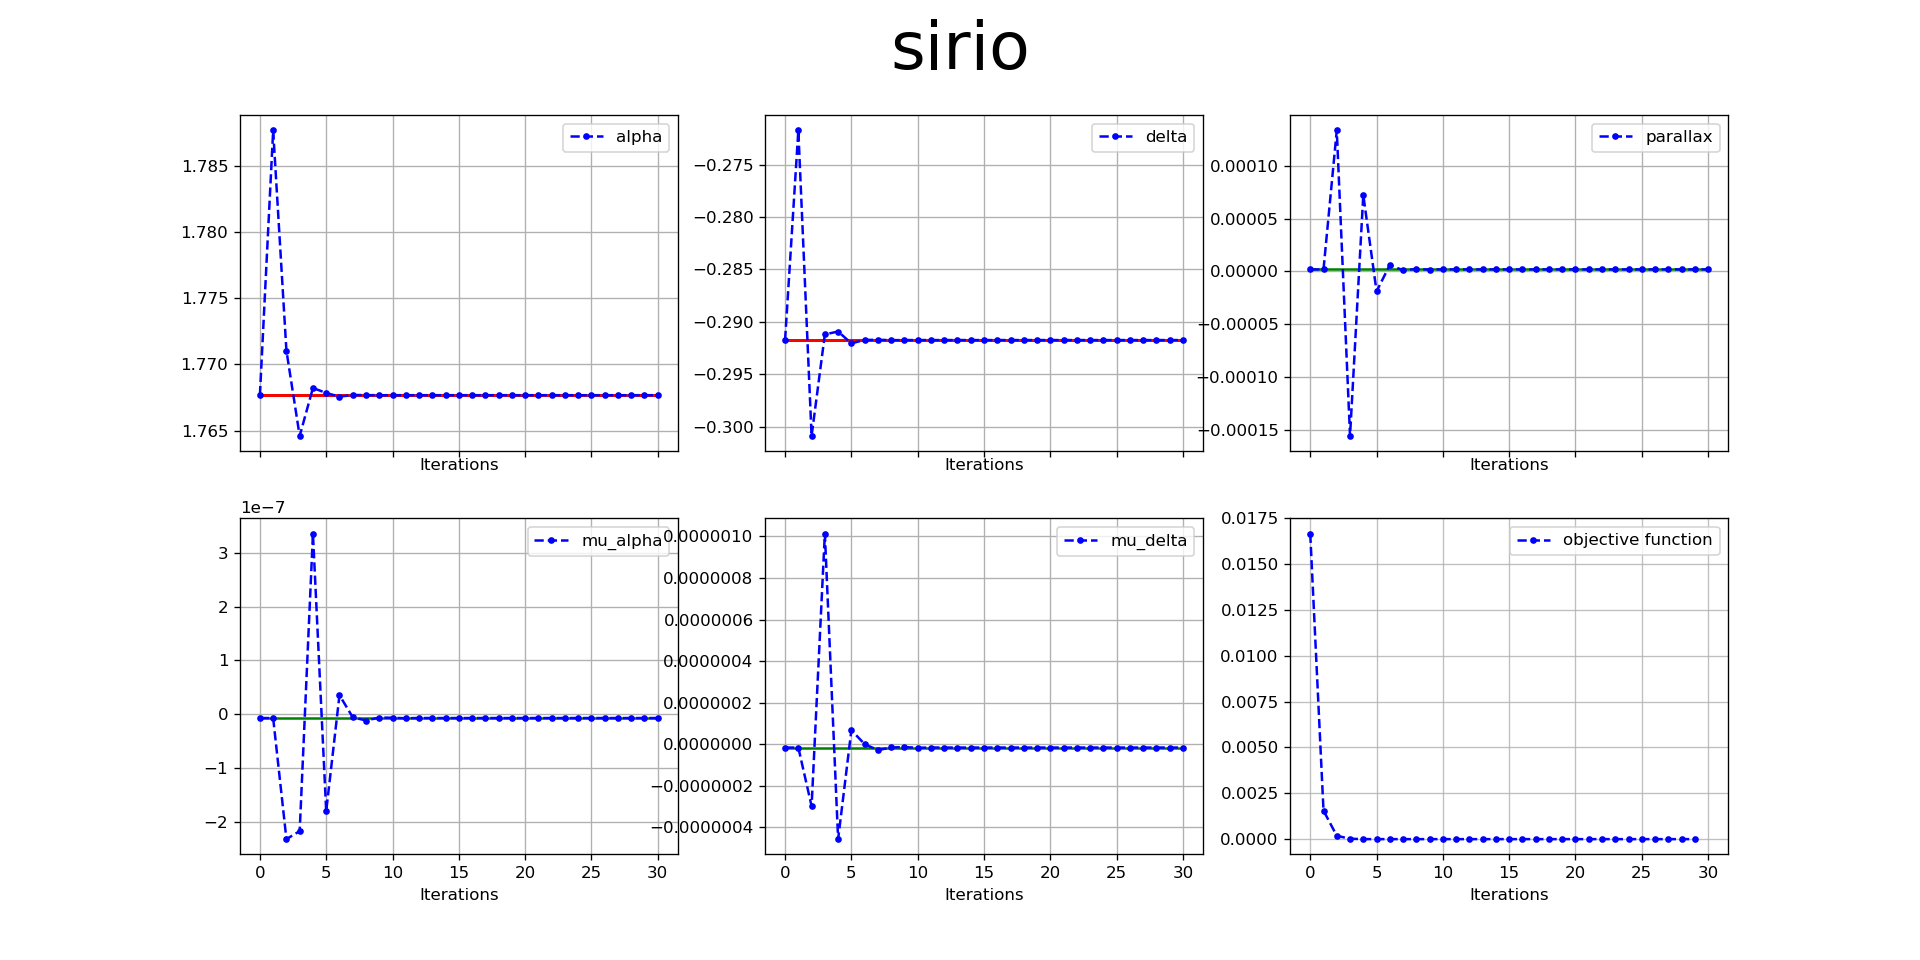

<IPython.core.display.Javascript object>


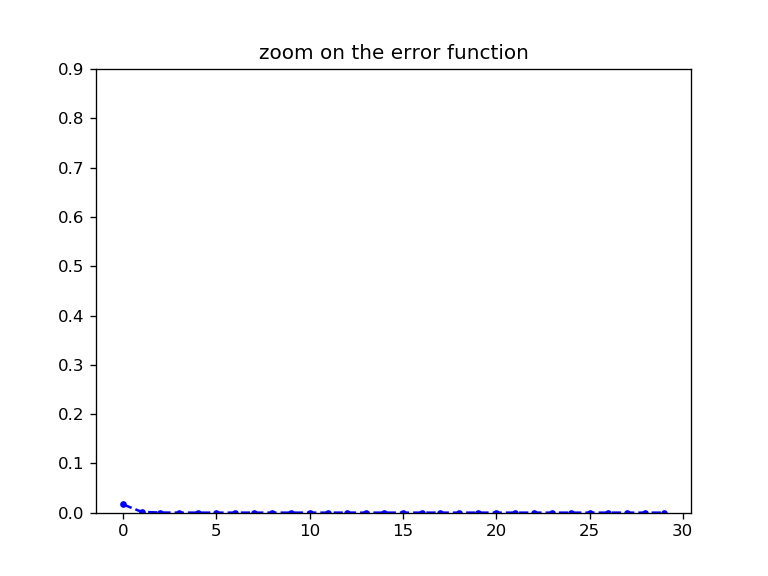

'running'

In [55]:
titles = ['sirio']
my_observations = scanSirio.obs_times
for source_index in range(len(Solver.calc_sources)):
    calc_source = Solver.calc_sources[source_index]
    real_source = Solver.real_sources[source_index]
    
    source_params = np.array(calc_source.s_old)
    fig, axs = plt.subplots(2, 3, figsize=(16,8), sharex='all')
    
    fig.suptitle(titles[source_index], fontsize=40)
    
    num_iters = len(calc_source.errors)
    labels = ['alpha', 'delta', 'parallax', 'mu_alpha', 'mu_delta']
    sirio.set_time(0)
    observed = [real_source.alpha, real_source.delta, real_source.parallax, real_source.mu_alpha_dx, real_source.mu_delta]

    alpha_list = []
    delta_list = []
    for t_L in my_observations:
        real_source.set_time(float(t_L))
        alpha_list.append(real_source.alpha)
        delta_list.append(real_source.delta)
    std_alpha = np.std(alpha_list)
    std_delta = np.std(delta_list)
    min_alpha, max_alpha = (np.min(alpha_list), np.max(alpha_list))
    min_delta, max_delta = (np.min(delta_list), np.max(delta_list))

    for i, x in enumerate(source_params.T):
        if i<3:
            ax = axs[0, i]
        else:
            ax = axs[1, i-3]
        ax.plot(x, 'b--.', label=labels[i])
        ax.hlines(observed[i], xmin=0, xmax=num_iters, color='g')
        ax.grid()
        ax.set_label('labels[i]')
        ax.set_xlabel('Iterations')
        ax.legend()

    axs[0,0].hlines(observed[0]+std_alpha, xmin=0, xmax=num_iters, color='g')
    axs[0,0].hlines(observed[0]-std_alpha, xmin=0, xmax=num_iters, color='g')
    axs[0,0].hlines(min_alpha, xmin=0, xmax=num_iters, color='r')
    axs[0,0].hlines(max_alpha, xmin=0, xmax=num_iters, color='r')

    axs[0,1].hlines(observed[1]+std_delta, xmin=0, xmax=num_iters, color='g')
    axs[0,1].hlines(observed[1]-std_delta, xmin=0, xmax=num_iters, color='g')
    axs[0,1].hlines(min_delta, xmin=0, xmax=num_iters, color='r')
    axs[0,1].hlines(max_delta, xmin=0, xmax=num_iters, color='r')

    # plot evolution of the error
    ax = axs[-1, -1] 
    ax.plot(calc_source.errors, 'b--.', label='objective function')
    # ax.set_xlim((0, num_iters))
    ax.set_xlabel('Iterations')
    ax.grid(alpha= 0.8)  
    ax.legend()


    fig.savefig('./figures/tmp/errors')

f3 = plt.figure()
plt.title('zoom on the error function')
plt.plot(calc_source.errors, 'b--.', label='objective function')
plt.ylim((0,0.9))
'running'